In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm 
import itertools
import sklearn.feature_selection
import sklearn.model_selection as ms
import pickle
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import datetime
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from scipy.stats import skew
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
from scipy import stats
from sklearn.preprocessing import normalize
from scipy.stats import skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
plt.style.use('ggplot')
pd.options.display.max_columns = None
pd.options.display.max_rows = 600

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
# Adding 'type' columns that contains 'train' or 'test', and add empty SalePrice columns to the test part
train.insert(0, 'type', 'train')
test.insert(0,'type','test')
test['SalePrice'] = 0.0

# merging the two dataframes
merged = pd.concat([train,test],axis=0).reset_index(drop=True)
merged['SalePrice'] = merged['SalePrice'].astype('float')

# Data cleaning
import Dprocessv5
train = Dprocessv5.dataProcess(merged);

In [4]:
# numerical and categorical features + EXCLUDED FIRST
excl_features = merged[['Id','type','SalePrice']].columns
cat_features = merged.select_dtypes(include = ["object"]).columns.drop('type')
num_features = merged.select_dtypes(exclude = ["object"]).columns.drop(['Id','SalePrice'])

mergedNum = merged[num_features]
mergedCat = merged[cat_features]
mergedExc = merged[excl_features]

mergedNAtotal = merged.isnull().sum().sort_values(ascending=False)

print("NAs for numerical features in merged : " + str(mergedNum.isnull().values.sum()))

if mergedNum.isnull().values.sum() != 0:
    mergedNum = mergedNum.fillna(mergedNum.median())
    print("Remaining NAs for numerical features in merged : " + str(mergedNum.isnull().values.sum()))

NAs for numerical features in merged : 0


In [5]:
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics2 = []
for i in merged.columns:
    if merged[i].dtype in numeric_dtypes: 
        numerics2.append(i)

skew_features = merged[numerics2].apply(lambda x: skew(x)).sort_values(ascending=False)
skews = pd.DataFrame({'skew':skew_features})

In [6]:
high_skew = skew_features[skew_features > 0.5]
high_skew = high_skew
skew_index = high_skew.index

for i in skew_index:
    if i != 'SalePrice':
        merged[i]= boxcox1p(merged[i], boxcox_normmax(merged[i]+1))

        
skew_features2 = merged[numerics2].apply(lambda x: skew(x)).sort_values(ascending=False)
skews2 = pd.DataFrame({'skew':skew_features2})

In [7]:
# Create dummy features for categorical values via one-hot encoding

print("Remaining NAs for categorical features in merged : " + str(mergedCat.isnull().values.sum()))

print("NAs for categorical features in merged : " + str(mergedCat.isnull().values.sum()))

mergedCat = pd.get_dummies(mergedCat)


Remaining NAs for categorical features in merged : 0
NAs for categorical features in merged : 0


In [8]:
# rejoin excluded, categorical and numerical features
merged = pd.concat([mergedExc,mergedNum, mergedCat], axis = 1)

print("New number of features : " + str(merged.shape[1]))

New number of features : 335


In [9]:
merged.shape

(2915, 335)

In [10]:
train = merged[merged['type'] == 'train'].copy()
train.drop(columns=['Id','type'],inplace=True)
test = merged[merged['type'] == 'test'].copy()
test.drop(columns=['type','SalePrice'],inplace=True)

In [11]:
# taking the log of the saleprice

train['SalePrice'] = np.log(train['SalePrice'])
train['SalePrice'].describe()

count    1456.000000
mean       12.022909
std         0.398649
min        10.460242
25%        11.774520
50%        12.001505
75%        12.273731
max        13.534473
Name: SalePrice, dtype: float64

### Linear Regression

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import sklearn.model_selection as ms
from scipy.stats import norm
from scipy.stats import skew
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.ensemble import (GradientBoostingRegressor , RandomForestRegressor,
                              BaggingRegressor,ExtraTreesRegressor,AdaBoostRegressor)
from scipy import stats
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, make_scorer
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

pd.set_option('display.max_columns', 85)
pd.set_option('display.max_rows', 85)

In [13]:
y = train.SalePrice

## Defining the train/test split (80/20)

In [14]:
house_features = train.drop('SalePrice',axis = 1)
prices = train['SalePrice']

x_train, x_test, y_train, y_test = ms.train_test_split(house_features, prices, 
                                                       test_size=0.2, random_state=111)

## Ridge

In [15]:
# 981 
# 0.12077
# R2: 94.20%
# trainRMSE: 9.69%
# testRMSE: 10%18%

ridcv = RidgeCV(alphas=np.linspace(1e-5,30,10000), normalize=False, scoring=None)

ridcv.fit(x_train,y_train)

trainRMSE = np.sqrt(mean_squared_error(y_true=y_train, y_pred=ridcv.predict(x_train)))
testRMSE = np.sqrt(mean_squared_error(y_true=y_test, y_pred=ridcv.predict(x_test)))

print('The best alpha is: {:.6}\n\nThe ridge intercept is: {:.2f}\n\n{}\n\nThe model score is {:.2%}\n\nTrain RMSE: {:.2%}\n\nTest RMSE: {:.2%}\n\nDiff in RMSE: {:.0%}\n\n'.format(
    ridcv.alpha_,ridcv.intercept_, pd.Series(ridcv.coef_, index=x_train.columns), ridcv.score(x_train, y_train), trainRMSE,testRMSE,(testRMSE - trainRMSE)))

# pd.DataFrame({'Id': test['Id'], 'SalePrice': np.exp(ridcv.predict(test.drop(columns='Id')))}
#             ).to_csv('ridcv {}.csv'.format(str(datetime.datetime.now())[:19].replace(':','.')
#                                            ), index=False)

The best alpha is: 20.243

The ridge intercept is: 5.31

LotFrontage              0.000490
LotArea                  0.000002
OverallQual              0.050000
OverallCond              0.040034
YearBuilt                0.002033
YearRemodAdd             0.000680
MasVnrArea               0.000026
BsmtFinSF1               0.000058
BsmtFinSF2               0.000044
BsmtUnfSF               -0.000011
TotalBsmtSF              0.000091
1stFlrSF                 0.000106
2ndFlrSF                 0.000094
LowQualFinSF            -0.000033
GrLivArea                0.000166
BsmtFullBath             0.020115
BsmtHalfBath             0.005169
FullBath                 0.020434
HalfBath                 0.028653
BedroomAbvGr            -0.004379
KitchenAbvGr            -0.013573
TotRmsAbvGrd            -0.000793
Fireplaces               0.003851
GarageYrBlt             -0.000037
GarageCars               0.023184
GarageArea               0.000080
WoodDeckSF               0.000088
OpenPorchSF              

In [16]:
#  
# 
# R2: 
# trainRMSE: 
# testRMSE: 

ridge = Ridge()
parameters = {'alpha':np.linspace(20,25,1000)}
ridgegs = ms.GridSearchCV(ridge, parameters, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
ridgegs.fit(x_train, y_train)

trainRMSE = np.sqrt(mean_squared_error(y_true=y_train, y_pred=ridgegs.predict(x_train)))
testRMSE = np.sqrt(mean_squared_error(y_true=y_test, y_pred=ridgegs.predict(x_test)))

ridgegs.best_params_


# print('The best parameters are: {}\n\nThe ridge intercept is: {:.2f}\n\n{}\n\nThe model score is {:.2%}\n\nTrain RMSE: {:.2%}\n\nTest RMSE: {:.2%}\n\nDiff in RMSE: {:.0%}\n\n'.format(
#     ridgegs.alpha_,ridgegs.intercept_, pd.Series(ridgegs.coef_, index=x_train.columns), ridgegs.score(x_train, y_train), trainRMSE,testRMSE,(testRMSE - trainRMSE)))

{'alpha': 20.865865865865867}

In [17]:
ridcv = RidgeCV(alphas=[20.865865865865867], normalize=False, scoring=None)

ridcv.fit(x_train,y_train)

trainRMSE = np.sqrt(mean_squared_error(y_true=y_train, y_pred=ridcv.predict(x_train)))
testRMSE = np.sqrt(mean_squared_error(y_true=y_test, y_pred=ridcv.predict(x_test)))

print('The best alpha is: {:.6}\n\nThe ridge intercept is: {:.2f}\n\n{}\n\nThe model score is {:.2%}\n\nTrain RMSE: {:.2%}\n\nTest RMSE: {:.2%}\n\nDiff in RMSE: {:.0%}\n\n'.format(
    ridcv.alpha_,ridcv.intercept_, pd.Series(ridcv.coef_, index=x_train.columns), ridcv.score(x_train, y_train), trainRMSE,testRMSE,(testRMSE - trainRMSE)))

# pd.DataFrame({'Id': test['Id'], 'SalePrice': np.exp(ridcv.predict(test.drop(columns='Id')))}
#             ).to_csv('ridcv {}.csv'.format(str(datetime.datetime.now())[:19].replace(':','.')
#                                            ), index=False)

The best alpha is: 20.8659

The ridge intercept is: 5.30

LotFrontage              0.000490
LotArea                  0.000002
OverallQual              0.050111
OverallCond              0.040105
YearBuilt                0.002037
YearRemodAdd             0.000682
MasVnrArea               0.000027
BsmtFinSF1               0.000058
BsmtFinSF2               0.000044
BsmtUnfSF               -0.000011
TotalBsmtSF              0.000092
1stFlrSF                 0.000106
2ndFlrSF                 0.000094
LowQualFinSF            -0.000034
GrLivArea                0.000166
BsmtFullBath             0.020023
BsmtHalfBath             0.005044
FullBath                 0.020205
HalfBath                 0.028476
BedroomAbvGr            -0.004439
KitchenAbvGr            -0.013456
TotRmsAbvGrd            -0.000776
Fireplaces               0.004017
GarageYrBlt             -0.000035
GarageCars               0.023098
GarageArea               0.000080
WoodDeckSF               0.000088
OpenPorchSF             

## Elastic-net

In [18]:
# 917
# 0.11994
# R2: 0.9359
# trainRMSE: 0.101935
# testRMSE: 0.100320
# diff: -0.002

enet = ElasticNetCV(l1_ratio=np.linspace(0.01,1,100), alphas=np.linspace(1e-5,20,1000), max_iter=1000, normalize=False, cv=10, n_jobs=-1)

enet.fit(x_train, y_train)

trainRMSE = np.sqrt(mean_squared_error(y_true=y_train, y_pred=enet.predict(x_train)))
testRMSE = np.sqrt(mean_squared_error(y_true=y_test, y_pred=enet.predict(x_test)))

print('The best alpha is: {:.6}\n\nThe elastic-net intercept is: {:.2f}\n\n{}\n\nThe model score is {:.2%}\n\nTrain RMSE: {:.2%}\n\nTest RMSE: {:.2%}\n\nDiff in RMSE: {:.0%}\n\n'.format(
    enet.alpha_,enet.intercept_, pd.Series(enet.coef_, index=x_train.columns), enet.score(x_train, y_train), trainRMSE,testRMSE,(testRMSE - trainRMSE)))

# pd.DataFrame({'Id': test['Id'], 'SalePrice': np.exp(enet.predict(test.drop(columns='Id')))}
#             ).to_csv('enet {}.csv'.format(str(datetime.datetime.now())[:19].replace(':','.')
#                                            ), index=False)

The best alpha is: 0.02003

The elastic-net intercept is: 4.94

LotFrontage              0.000495
LotArea                  0.000002
OverallQual              0.052813
OverallCond              0.041749
YearBuilt                0.002131
YearRemodAdd             0.000700
MasVnrArea               0.000030
BsmtFinSF1               0.000127
BsmtFinSF2               0.000109
BsmtUnfSF                0.000054
TotalBsmtSF              0.000036
1stFlrSF                 0.000232
2ndFlrSF                 0.000227
LowQualFinSF             0.000083
GrLivArea                0.000036
BsmtFullBath             0.017955
BsmtHalfBath             0.000580
FullBath                 0.015178
HalfBath                 0.024915
BedroomAbvGr            -0.004940
KitchenAbvGr            -0.012071
TotRmsAbvGrd            -0.000705
Fireplaces               0.005884
GarageYrBlt              0.000037
GarageCars               0.022167
GarageArea               0.000086
WoodDeckSF               0.000089
OpenPorchSF       

In [19]:
# 917
# 0.11994
# R2: 0.9359
# trainRMSE: 0.101935
# testRMSE: 0.100320
# diff: -0.002

elasticnet = ElasticNet(max_iter=1000, normalize=False)
parameters = {'alpha':np.linspace(1e-5,20,1000), 'l1_ratio':np.linspace(0.01,1,100)}

elastgs = ms.GridSearchCV(elasticnet, parameters, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
elastgs.fit(x_train, y_train)

trainRMSE = np.sqrt(mean_squared_error(y_true=y_train, y_pred=elastgs.predict(x_train)))
testRMSE = np.sqrt(mean_squared_error(y_true=y_test, y_pred=elastgs.predict(x_test)))

elastgs.best_params_

pickle.dump(elastgs, open('elastgs', 'wb'))

# pd.DataFrame({'Id': test['Id'], 'SalePrice': np.exp(enet.predict(test.drop(columns='Id')))}
#             ).to_csv('enet {}.csv'.format(str(datetime.datetime.now())[:19].replace(':','.')
#                                            ), index=False)

KeyboardInterrupt: 

In [ ]:
# 
# 
# R2: 
# trainRMSE: 
# testRMSE: 
# diff: 

parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
svc = svm.SVC(gamma="scale")
clf = GridSearchCV(svc, parameters, cv=5)
clf.fit(iris.data, iris.target)

enet = ElasticNetCV(l1_ratio=np.linspace(0.01,1,100), alphas=np.linspace(1e-5,20,1000), max_iter=1000, normalize=False, cv=10, n_jobs=-1)

enet.fit(x_train, y_train)

trainRMSE = np.sqrt(mean_squared_error(y_true=y_train, y_pred=enet.predict(x_train)))
testRMSE = np.sqrt(mean_squared_error(y_true=y_test, y_pred=enet.predict(x_test)))

print('The best alpha is: {:.6}\n\nThe elastic-net intercept is: {:.2f}\n\n{}\n\nThe model score is {:.2%}\n\nTrain RMSE: {:.2%}\n\nTest RMSE: {:.2%}\n\nDiff in RMSE: {:.0%}\n\n'.format(
    enet.alpha_,enet.intercept_, pd.Series(enet.coef_, index=x_train.columns), enet.score(x_train, y_train), trainRMSE,testRMSE,(testRMSE - trainRMSE)))

# pd.DataFrame({'Id': test['Id'], 'SalePrice': np.exp(enet.predict(test.drop(columns='Id')))}
#             ).to_csv('enet {}.csv'.format(str(datetime.datetime.now())[:19].replace(':','.')
#                                            ), index=False)

## Lasso

In [ ]:
#  alpha           UJ range              np.linspace(1e-4,1e-2,1000)
#  CV          100         10          100
# R2:        0.9366      0.9399      0.9374
# trainRMSE: 0.101363    0.098698    0.100718
# testRMSE:  0.100012    0.100196    0.099977
# diff:b       0.00       0.00         0.00

lassocv = LassoCV(alphas=np.linspace(1e-4,1e-3,1000), normalize=False,
                      max_iter=10000, n_jobs=-1, cv=100)

lassocv.fit(x_train, y_train)

trainRMSE = np.sqrt(mean_squared_error(y_true=y_train, y_pred=lassocv.predict(x_train)))
testRMSE = np.sqrt(mean_squared_error(y_true=y_test, y_pred=lassocv.predict(x_test)))

print('The best alpha is: {:.6}\n\nThe lasso intercept is: {:.2f}\n\n{}\n\nThe model score is {:.2%}\n\nTrain RMSE: {:.2%}\n\nTest RMSE: {:.2%}\n\nDiff in RMSE: {:.0%}\n\n'.format(
    lassocv.alpha_,lassocv.intercept_, pd.Series(lassocv.coef_, index=x_train.columns), lassocv.score(x_train, y_train), trainRMSE,testRMSE,(testRMSE - trainRMSE)))

# pd.DataFrame({'Id':test['Id'],'SalePrice': np.exp(lassocv.predict(test.drop(columns='Id')))}
#             ).to_csv('lasso {}.csv'.format(str(datetime.datetime.now())[:19].replace(':','.')
#                                            ), index=False)

## Random Forest

In [ ]:
rf = RandomForestRegressor(n_estimators=1000,max_depth=10,max_features=0.5, min_samples_split=2, min_samples_leaf=1,n_jobs=-1)
rf.fit(x_train, y_train)

scores = ms.cross_val_score(rf, x_train, y_train, cv=10)

print(scores.mean())

trainRMSE = np.sqrt(mean_squared_error(y_true=y_train, y_pred=rf.predict(x_train)))
testRMSE = np.sqrt(mean_squared_error(y_true=y_test, y_pred=rf.predict(x_test)))

print('\nThe model score is {:.2%}\n\nTrain RMSE: {:.2%}\n\nTest RMSE: {:.2%}\n\nDiff in RMSE: {:.0%}\n\n'.format(
    rf.score(x_train, y_train), trainRMSE,testRMSE,(testRMSE - trainRMSE)))

# pd.DataFrame({'Id':test['Id'],'SalePrice': np.exp(rf.predict(test.drop(columns='Id')))}
#             ).to_csv('rf {}.csv'.format(str(datetime.datetime.now())[:19].replace(':','.')
#                                            ), index=False)

# 1000 trees
# 0.8395225412896815
# R2: 0.9517
# Train RMSE: 0.088419
# Test RMSE: 0.129310
# Diff in RMSE: 0.041

### Looping over max tree depth

In [ ]:
for i in range(1,11):
    rf = RandomForestRegressor(n_estimators=500,max_depth=i,max_features='auto', min_samples_split=2, min_samples_leaf=1,n_jobs=-1)
    rf.fit(x_train, y_train)

    scores = ms.cross_val_score(rf, x_train, y_train, cv=10)
    print('trial with depth = {}'.format(i))
    print(scores.mean())

    trainRMSE = np.sqrt(mean_squared_error(y_true=y_train, y_pred=rf.predict(x_train)))
    testRMSE = np.sqrt(mean_squared_error(y_true=y_test, y_pred=rf.predict(x_test)))

    print('\nThe model score is {:.2%}\n\nTrain RMSE: {:.2%}\n\nTest RMSE: {:.2%}\n\nDiff in RMSE: {:.0%}\n\n'.format(
        rf.score(x_train, y_train), trainRMSE,testRMSE,(testRMSE - trainRMSE)))



### Looping over percentage of features for each tree

In [ ]:
for i in np.linspace(0.05,1.0,20):
    rf = RandomForestRegressor(n_estimators=500,max_depth=10,max_features=i, min_samples_split=2, min_samples_leaf=1,n_jobs=-1)
    rf.fit(x_train, y_train)

    scores = ms.cross_val_score(rf, x_train, y_train, cv=10)
    print('trial with depth = {}'.format(i))
    print(scores.mean())

    trainRMSE = np.sqrt(mean_squared_error(y_true=y_train, y_pred=rf.predict(x_train)))
    testRMSE = np.sqrt(mean_squared_error(y_true=y_test, y_pred=rf.predict(x_test)))

    print('\nThe model score is {:.2%}\n\nTrain RMSE: {:.2%}}\n\nTest RMSE: {:.2%}\n\nDiff in RMSE: {:.2%}\n\n'.format(
        rf.score(x_train, y_train), trainRMSE,testRMSE,(testRMSE - trainRMSE)))


## Gradient Boosting

In [ ]:
gbst = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =111)

gbst.fit(x_train, y_train)

trainRMSE = np.sqrt(mean_squared_error(y_true=y_train, y_pred=gbst.predict(x_train)))
testRMSE = np.sqrt(mean_squared_error(y_true=y_test, y_pred=gbst.predict(x_test)))

print('\nThe model score is {:.2%}\n\nTrain RMSE: {:.2%}\n\nTest RMSE: {:.2%}\n\nDiff in RMSE: {:.0%}\n\n'.format(
    gbst.score(x_train, y_train), trainRMSE,testRMSE,(testRMSE - trainRMSE)))

# pd.DataFrame({'Id':test['Id'],'SalePrice': np.exp(gbst.predict(test.drop(columns='Id')))}
#             ).to_csv('gbst {}.csv'.format(str(datetime.datetime.now())[:19].replace(':','.')
#                                            ), index=False)

## XGBoost

In [ ]:
# read in data
dtrain = xgb.DMatrix(x_train)
dtest = xgb.DMatrix(x_test)
# specify parameters via map
param = {'max_depth':2, 'eta':1,'booster':'gbtree', 'objective':'reg:linear' }
num_round = 2
bst = xgb.train(param, dtrain, num_round)
# make prediction
preds = bst.predict(dtest)

trainRMSE = np.sqrt(mean_squared_error(y_true=y_train, y_pred=bst.predict(x_train)))
testRMSE = np.sqrt(mean_squared_error(y_true=y_test, y_pred=bst.predict(x_test)))

print('\nThe model score is {:.2%}\n\nTrain RMSE: {:.2%}\n\nTest RMSE: {:.2%}\n\nDiff in RMSE: {:.0%}\n\n'.format(
        bst.score(x_train, y_train), trainRMSE,testRMSE,(testRMSE - trainRMSE)))

## Output csv

In [ ]:
# pd.DataFrame({'Id': test['Id'], 'SalePrice': np.exp(ridcv.predict(test.drop(columns='Id')))}
#             ).to_csv('ridcv {}.csv'.format(str(datetime.datetime.now())[:19].replace(':','.')
#                                            ), index=False)
# pd.DataFrame({'Id': test['Id'], 'SalePrice': np.exp(enet.predict(test.drop(columns='Id')))}
#             ).to_csv('enet {}.csv'.format(str(datetime.datetime.now())[:19].replace(':','.')
#                                            ), index=False)
# pd.DataFrame({'Id':test['Id'],'SalePrice': np.exp(lassocv.predict(test.drop(columns='Id')))}
#             ).to_csv('lasso {}.csv'.format(str(datetime.datetime.now())[:19].replace(':','.')
#                                            ), index=False)
# pd.DataFrame({'Id':test['Id'],'SalePrice': np.exp(rf.predict(test.drop(columns='Id')))}
#             ).to_csv('rf {}.csv'.format(str(datetime.datetime.now())[:19].replace(':','.')
#                                            ), index=False)
# pd.DataFrame({'Id':test['Id'],'SalePrice': np.exp(xgb_model.predict(test.drop(columns='Id')))}
#             ).to_csv('xgb_model {}.csv'.format(str(datetime.datetime.now())[:19].replace(':','.')
#                                            ), index=False)

# All Scores

In [10]:
Scores = {'Ridge': 10.18, "Lasso": .099977, "Elastic Net":  0.100320, 'Random Forest': 0.129310}

In [18]:
pd.DataFrame(Scores)

ValueError: If using all scalar values, you must pass an index

In [ ]:
Ridge: 0.11781
ElasticNet: 0.11807
Lasso: 0.11920

gradient boost: 0.12167
    
lgbm is 12.080

xgboost 12.125

In [35]:
df = pd.DataFrame({'Model Type': ['Ridge',"Lasso","Elastic Net",'Random Forest',"Gradient Boosting", "XGBoost", "LGBM"],
          'Scores': [.11781, .11920, 0.11807, 0.14231, .12167, .12125, .12125]})
df = df.sort_values(by=['Scores'], ascending=True)
df = df.set_index('Model Type')
df

,Scores
Model Type,
Ridge,0.11781
Elastic Net,0.11807
Lasso,0.11920
XGBoost,0.12125
LGBM,0.12125
Gradient Boosting,0.12167
Random Forest,0.14231


In [ ]:
# Bar chart of model scores
from matplotlib.pyplot import figure
plt.bar(df['Model Type'], df['Scores'])
plt.title('Model RMSE Scores')
plt.ylabel('RMSE Score')
plt.xlabel('Model')
matplotlib.pyplot.ylim((0.098, .118)) 
# plt.savefig('./Scores_Bar_Graph.png', dpi=300)
plt.figure(figsize=(15,15))
plt.show()

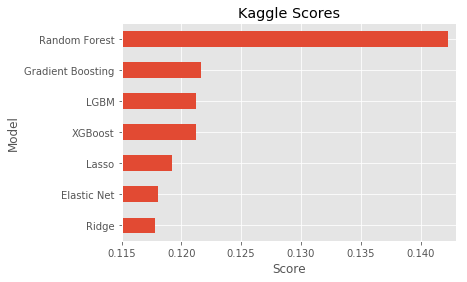

<Figure size 1080x1080 with 0 Axes>

In [39]:
from matplotlib.pyplot import figure

df.plot(kind='barh', legend=None)
plt.title('Kaggle Scores')
plt.ylabel('Model')
plt.xlabel('Score')
matplotlib.pyplot.xlim((0.115, .143)) 
plt.savefig('Kagglescores.png', dpi=300, bbox_inches='tight')
plt.figure(figsize=(15,15))


 

plt.show()